In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, roc_auc_score, roc_curve, silhouette_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize

import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


2025-11-13 15:19:41.907424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763047181.930846     853 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763047181.938011     853 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


# Dataset Preparation

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import glob
from sklearn.model_selection import train_test_split


class NestedImageDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Root directory containing class-wise folders.
        """
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(root_dir))}
        
        for class_name in os.listdir(root_dir):
            class_folder = os.path.join(root_dir, class_name)
            if os.path.isdir(class_folder):
                for img_path in glob.glob(os.path.join(class_folder, '**', '*.*'), recursive=True):
                    if img_path.lower().endswith(('.jpg', '.jpeg', '.png')): 
                        self.image_paths.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")  # Return PIL Image
        return image, label


root_dir = '/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset'

dataset = NestedImageDataset(root_dir=root_dir)

print(f"Total samples in the dataset: {len(dataset)}")
for i in range(5):  
    img, label = dataset[i]
    print(f"Sample {i}: Label {label}, Type: {type(img)}")


if len(dataset.image_paths) > 0:
    train_paths, test_paths = train_test_split(dataset.image_paths, test_size=0.2, random_state=42)

    # Create separate datasets for train and test
    train_dataset = NestedImageDataset(root_dir=root_dir)
    train_dataset.image_paths = train_paths
    train_dataset.labels = [dataset.labels[i] for i in range(len(dataset.image_paths)) if dataset.image_paths[i] in train_paths]

    test_dataset = NestedImageDataset(root_dir=root_dir)
    test_dataset.image_paths = test_paths
    test_dataset.labels = [dataset.labels[i] for i in range(len(dataset.image_paths)) if dataset.image_paths[i] in test_paths]

    print(f"Train samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
else:
    print("No images found. Please check your directory structure.")


Total samples in the dataset: 375
Sample 0: Label 0, Type: <class 'PIL.Image.Image'>
Sample 1: Label 0, Type: <class 'PIL.Image.Image'>
Sample 2: Label 0, Type: <class 'PIL.Image.Image'>
Sample 3: Label 0, Type: <class 'PIL.Image.Image'>
Sample 4: Label 0, Type: <class 'PIL.Image.Image'>
Train samples: 300
Test samples: 75


# SimCLR Augmentation Pipeline

In [3]:
class SimCLRAugmentation:
    """
    SimCLR uses two random augmentations of the same image.
    Augmentation recipe: random crop, color jitter, grayscale, gaussian blur, flip
    """
    def __init__(self, size=32):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
    
    def __call__(self, x):
        return self.transform(x), self.transform(x)


class SimCLRDataset(Dataset):
    """Wrapper dataset that applies SimCLR augmentations"""
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.augment = SimCLRAugmentation()
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        img1, img2 = self.augment(img)
        return img1, img2, label


simclr_train_dataset = SimCLRDataset(train_dataset)
simclr_train_loader = DataLoader(simclr_train_dataset, batch_size=256, 
                                  shuffle=True, num_workers=2, pin_memory=True)


# SimCLR Model Architecture

In [4]:


class SimCLR(nn.Module):
    """
    SimCLR model with ResNet18 encoder and projection head.
    The encoder produces features, the projection head is used only during pretraining.
    """
    def __init__(self, feature_dim=128):
        super(SimCLR, self).__init__()
        
        # Encoder: ResNet18 backbone
        self.encoder = resnet18(pretrained=False)
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, 
                                        padding=1, bias=False)
        self.encoder.maxpool = nn.Identity()
        
        # Get feature dimension
        self.feature_dim_encoder = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        
        # Projection head: 2-layer MLP
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim_encoder, self.feature_dim_encoder),
            nn.ReLU(),
            nn.Linear(self.feature_dim_encoder, feature_dim)
        )
    
    def forward(self, x):
        h = self.encoder(x)  # Features from encoder
        z = self.projection_head(h)  # Projected features
        return h, z


model = SimCLR(feature_dim=128).to(device)
print(f"Encoder feature dimension: {model.feature_dim_encoder}")

Encoder feature dimension: 512


In [5]:
class NTXentLoss(nn.Module):
    """
    Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)
    This is the contrastive loss used in SimCLR
    """
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
    
    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        
        # Normalize features
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Concatenate
        z = torch.cat([z_i, z_j], dim=0)
        
        # Compute similarity matrix
        sim_matrix = torch.mm(z, z.t()) / self.temperature
        
        # Create mask to remove self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
        sim_matrix.masked_fill_(mask, -9e15)
        
        # Positive pairs: (i, i+batch_size) and (i+batch_size, i)
        pos_sim = torch.cat([
            torch.diag(sim_matrix, batch_size),
            torch.diag(sim_matrix, -batch_size)
        ], dim=0)
        
        # Compute loss
        loss = -pos_sim + torch.logsumexp(sim_matrix, dim=1)
        loss = loss.mean()
        
        return loss


criterion = NTXentLoss(temperature=0.5)


# 4.1 Label free Pretrainning

In [6]:


def train_simclr(model, train_loader, epochs=100, lr=3e-4):
    """
    Pretrain SimCLR using contrastive learning on augmented views
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    losses = []
    
    print("Starting SimCLR pretraining...")
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for img1, img2, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            img1, img2 = img1.to(device), img2.to(device)
            
            # Forward pass
            _, z1 = model(img1)
            _, z2 = model(img2)
            
            # Compute loss
            loss = criterion(z1, z2)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    train_time = time.time() - start_time
    print(f"Pretraining completed in {train_time:.2f} seconds")
    
    return losses, train_time


# Train the model
pretrain_losses, pretrain_time = train_simclr(model, simclr_train_loader, epochs=50)

# Save the pretrained encoder
torch.save(model.encoder.state_dict(), 'simclr_encoder.pth')
print("Frozen encoder saved!")



Starting SimCLR pretraining...


Epoch 1/50: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Epoch 1/50 - Loss: 5.2607


Epoch 2/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 2/50 - Loss: 5.0947


Epoch 3/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 3/50 - Loss: 5.1069


Epoch 4/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 4/50 - Loss: 5.0084


Epoch 5/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 5/50 - Loss: 5.0192


Epoch 6/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 6/50 - Loss: 5.0285


Epoch 7/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 7/50 - Loss: 4.9442


Epoch 8/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 8/50 - Loss: 4.9609


Epoch 9/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 9/50 - Loss: 4.8482


Epoch 10/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 10/50 - Loss: 4.8784


Epoch 11/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 11/50 - Loss: 4.8518


Epoch 12/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 12/50 - Loss: 4.8406


Epoch 13/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 13/50 - Loss: 4.8847


Epoch 14/50: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch 14/50 - Loss: 4.7754


Epoch 15/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 15/50 - Loss: 4.7979


Epoch 16/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 16/50 - Loss: 4.7796


Epoch 17/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 17/50 - Loss: 4.7634


Epoch 18/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 18/50 - Loss: 4.9107


Epoch 19/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 19/50 - Loss: 4.8373


Epoch 20/50: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch 20/50 - Loss: 4.7542


Epoch 21/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 21/50 - Loss: 4.8606


Epoch 22/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 22/50 - Loss: 4.7812


Epoch 23/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 23/50 - Loss: 4.7976


Epoch 24/50: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Epoch 24/50 - Loss: 4.7116


Epoch 25/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 25/50 - Loss: 4.7767


Epoch 26/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 26/50 - Loss: 4.7279


Epoch 27/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 27/50 - Loss: 4.7236


Epoch 28/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 28/50 - Loss: 4.6773


Epoch 29/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 29/50 - Loss: 4.6866


Epoch 30/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 30/50 - Loss: 4.7594


Epoch 31/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 31/50 - Loss: 4.6575


Epoch 32/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 32/50 - Loss: 4.6517


Epoch 33/50: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch 33/50 - Loss: 4.7422


Epoch 34/50: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch 34/50 - Loss: 4.6218


Epoch 35/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 35/50 - Loss: 4.6481


Epoch 36/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 36/50 - Loss: 4.6270


Epoch 37/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 37/50 - Loss: 4.5901


Epoch 38/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 38/50 - Loss: 4.7076


Epoch 39/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 39/50 - Loss: 4.6018


Epoch 40/50: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch 40/50 - Loss: 4.5680


Epoch 41/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 41/50 - Loss: 4.8245


Epoch 42/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 42/50 - Loss: 4.6477


Epoch 43/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 43/50 - Loss: 4.5956


Epoch 44/50: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch 44/50 - Loss: 4.6375


Epoch 45/50: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch 45/50 - Loss: 4.6424


Epoch 46/50: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch 46/50 - Loss: 4.5901


Epoch 47/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 47/50 - Loss: 4.6485


Epoch 48/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 48/50 - Loss: 4.5830


Epoch 49/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 49/50 - Loss: 4.7328


Epoch 50/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 50/50 - Loss: 4.6873
Pretraining completed in 91.29 seconds
Frozen encoder saved!


# Extract Features from Encoder

In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from tqdm import tqdm

transform_base = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

class EvalDataset(Dataset):
    """Dataset wrapper applying base transform for evaluation."""
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        img = self.transform(img)
        return img, label

train_eval_dataset = EvalDataset(train_dataset, transform=transform_base)
test_eval_dataset  = EvalDataset(test_dataset, transform=transform_base)


train_loader_eval = DataLoader(train_eval_dataset, batch_size=256, shuffle=False, num_workers=2)
test_loader_eval  = DataLoader(test_eval_dataset, batch_size=256, shuffle=False, num_workers=2)

def extract_features(model, dataloader, return_labels=True):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            imgs, lbls = batch
            imgs = imgs.to(device)
            h, _ = model(imgs)
            features.append(h.cpu().numpy())
            if return_labels:
                labels.append(lbls.numpy())

    features = np.vstack(features)
    labels = np.concatenate(labels) if return_labels else None
    return features, labels


print("Extracting training features...")
X_train, y_train = extract_features(model, train_loader_eval)
print(f"Train features shape: {X_train.shape}")

print("Extracting test features...")
X_test, y_test = extract_features(model, test_loader_eval)
print(f"Test features shape: {X_test.shape}")


Extracting training features...


Extracting features: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Train features shape: (300, 512)
Extracting test features...


Extracting features: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Test features shape: (75, 512)


# 4.2 Downstream Evaluation- Linear Probe

In [8]:
def train_linear_probe(X_train, y_train, X_test, y_test):
    """
    Train a linear classifier on frozen features
    This is the primary SSL evaluation metric
    """
    print("\n=== Linear Probe Evaluation ===")
    start_time = time.time()
    
    clf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    test_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Linear Probe Accuracy: {accuracy:.4f}")
    print(f"Train time: {train_time:.2f}s, Test time: {test_time:.2f}s")
    
    return clf, y_pred, y_pred_proba, accuracy, train_time, test_time


linear_probe, linear_pred, linear_proba, linear_acc, lp_train_time, lp_test_time = \
    train_linear_probe(X_train, y_train, X_test, y_test)



=== Linear Probe Evaluation ===
Linear Probe Accuracy: 0.3333
Train time: 3.96s, Test time: 0.00s


# 4.2 Downstream Evaluation- Shallow Heads

In [9]:
def evaluate_shallow_heads(X_train, y_train, X_test, y_test):
    """
    Train various shallow classifiers on frozen features
    """
    results = {}

    print("\n=== MLP Classifier ===")
    from sklearn.neural_network import MLPClassifier
    start = time.time()
    mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    mlp_pred = mlp.predict(X_test)
    test_time = time.time() - start
    mlp_acc = accuracy_score(y_test, mlp_pred)
    print(f"MLP Accuracy: {mlp_acc:.4f}")
    results['MLP'] = {'accuracy': mlp_acc, 'train_time': train_time, 
                      'test_time': test_time, 'predictions': mlp_pred}
    
    print("\n=== SVM Classifier ===")
    start = time.time()
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train[:10000], y_train[:10000])  # Subsample for speed
    train_time = time.time() - start
    
    start = time.time()
    svm_pred = svm.predict(X_test)
    test_time = time.time() - start
    svm_acc = accuracy_score(y_test, svm_pred)
    print(f"SVM Accuracy: {svm_acc:.4f}")
    results['SVM'] = {'accuracy': svm_acc, 'train_time': train_time, 
                      'test_time': test_time, 'predictions': svm_pred}
    
    print("\n=== Decision Tree Classifier ===")
    start = time.time()
    dt = DecisionTreeClassifier(max_depth=20, random_state=42)
    dt.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    dt_pred = dt.predict(X_test)
    test_time = time.time() - start
    dt_acc = accuracy_score(y_test, dt_pred)
    print(f"Decision Tree Accuracy: {dt_acc:.4f}")
    results['DecisionTree'] = {'accuracy': dt_acc, 'train_time': train_time, 
                               'test_time': test_time, 'predictions': dt_pred}
    
    print("\n=== Random Forest Classifier ===")
    start = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    rf_pred = rf.predict(X_test)
    test_time = time.time() - start
    rf_acc = accuracy_score(y_test, rf_pred)
    print(f"Random Forest Accuracy: {rf_acc:.4f}")
    results['RandomForest'] = {'accuracy': rf_acc, 'train_time': train_time, 
                               'test_time': test_time, 'predictions': rf_pred}
    
    return results


shallow_results = evaluate_shallow_heads(X_train, y_train, X_test, y_test)


=== MLP Classifier ===
MLP Accuracy: 0.4000

=== SVM Classifier ===
SVM Accuracy: 0.3333

=== Decision Tree Classifier ===
Decision Tree Accuracy: 0.3200

=== Random Forest Classifier ===
Random Forest Accuracy: 0.3067


# 4.2 Downstream Evaluation - Full Fine Tuning

In [10]:
transform_base = transforms.Compose([
    transforms.Resize((32, 32)),       
    transforms.ToTensor(),             
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset_tf = TransformedDataset(train_dataset, transform=transform_base)
test_dataset_tf  = TransformedDataset(test_dataset, transform=transform_base)


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time

def full_finetune(model, train_dataset, test_dataset, epochs=20, lr=3e-4):
    """
    Fine-tune the frozen encoder with a linear classifier on top
    """

    class FineTuneModel(nn.Module):
        def __init__(self, encoder, feature_dim, num_classes=3):
            super().__init__()
            self.encoder = encoder
            self.fc = nn.Linear(feature_dim, num_classes)
            self.encoder.fc = nn.Identity()  # Keep Identity to extract features

        def forward(self, x):
            h = self.encoder(x)
            return self.fc(h)

    
    finetune_model = FineTuneModel(
        model.encoder, feature_dim=model.feature_dim_encoder, num_classes=4
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(finetune_model.parameters(), lr=lr, weight_decay=1e-6)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    
    finetune_model.train()
    start_time = time.time()
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = finetune_model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.4f} - "
              f"Accuracy: {correct/total:.4f}")

    ft_train_time = time.time() - start_time

    finetune_model.eval()
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = finetune_model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    ft_test_time = time.time() - start_time
    accuracy = correct / total

    print(f"Fine-tuning test accuracy: {accuracy:.4f}")
    return accuracy, ft_train_time, ft_test_time

finetune_acc, ft_train_time, ft_test_time = full_finetune(
    model, train_dataset_tf, test_dataset_tf, epochs=20
)



Epoch 1/20 - Loss: 0.6566 - Accuracy: 0.7667
Epoch 2/20 - Loss: 0.1384 - Accuracy: 0.9533
Epoch 3/20 - Loss: 0.0840 - Accuracy: 0.9700
Epoch 4/20 - Loss: 0.0801 - Accuracy: 0.9600
Epoch 5/20 - Loss: 0.0826 - Accuracy: 0.9567
Epoch 6/20 - Loss: 0.0975 - Accuracy: 0.9600
Epoch 7/20 - Loss: 0.0609 - Accuracy: 0.9767
Epoch 8/20 - Loss: 0.0617 - Accuracy: 0.9733
Epoch 9/20 - Loss: 0.0503 - Accuracy: 0.9733
Epoch 10/20 - Loss: 0.0543 - Accuracy: 0.9667
Epoch 11/20 - Loss: 0.0501 - Accuracy: 0.9667
Epoch 12/20 - Loss: 0.0494 - Accuracy: 0.9667
Epoch 13/20 - Loss: 0.0511 - Accuracy: 0.9733
Epoch 14/20 - Loss: 0.0542 - Accuracy: 0.9667
Epoch 15/20 - Loss: 0.0512 - Accuracy: 0.9733
Epoch 16/20 - Loss: 0.0549 - Accuracy: 0.9700
Epoch 17/20 - Loss: 0.0489 - Accuracy: 0.9667
Epoch 18/20 - Loss: 0.0485 - Accuracy: 0.9733
Epoch 19/20 - Loss: 0.0517 - Accuracy: 0.9733
Epoch 20/20 - Loss: 0.0492 - Accuracy: 0.9667
Fine-tuning test accuracy: 0.3867


# 4.3 Embedding Analysis- t-SNE


=== t-SNE Visualization ===


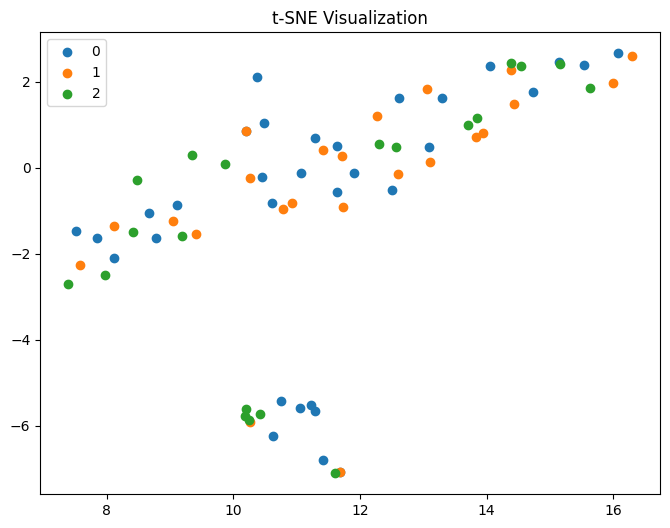

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(features, labels, n_samples=1000):
    print("\n=== t-SNE Visualization ===")
    
    n_samples = min(len(features), n_samples)  # fix: cannot sample more than available
    indices = np.random.choice(len(features), n_samples, replace=False)
    
    features_sub = features[indices]
    labels_sub = labels[indices]
    
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features_sub)
    
    plt.figure(figsize=(8,6))
    for lbl in np.unique(labels_sub):
        plt.scatter(features_2d[labels_sub==lbl,0], features_2d[labels_sub==lbl,1], label=str(lbl))
    plt.legend()
    plt.title("t-SNE Visualization")
    plt.show()
    
    return features_2d, labels_sub

tsne_features, tsne_sil = plot_tsne(X_test, y_test, n_samples=500)


#  4.3 Embedding Analysis - UMAP

In [ ]:
pip install --upgrade umap-learn scikit-learn


=== UMAP Visualization ===


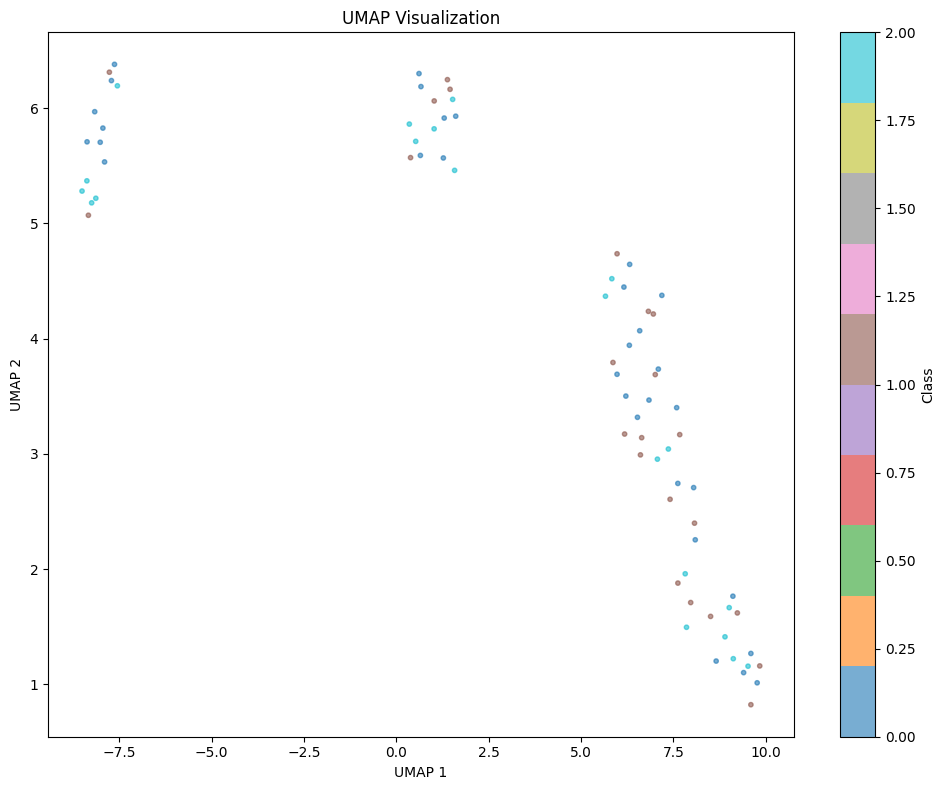

UMAP Silhouette Score: -0.0975


In [16]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def plot_umap(features, labels, n_samples=500):
    print("\n=== UMAP Visualization ===")

    n_samples = min(len(features), n_samples)
    indices = np.random.choice(len(features), n_samples, replace=False)
    features_sub = features[indices]
    labels_sub = labels[indices]

    # Legacy UMAP object (old versions)
    umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    features_2d = umap_model.fit_transform(features_sub)  # fits without extra args

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_sub, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Class')
    plt.title('UMAP Visualization')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.tight_layout()
    plt.show()

    sil_score = silhouette_score(features_2d, labels_sub)
    print(f"UMAP Silhouette Score: {sil_score:.4f}")
    
    return features_2d, sil_score



umap_features, umap_sil = plot_umap(X_test, y_test, n_samples=500)



#  4.3 Embedding Analysis - PCA


=== PCA Visualization ===


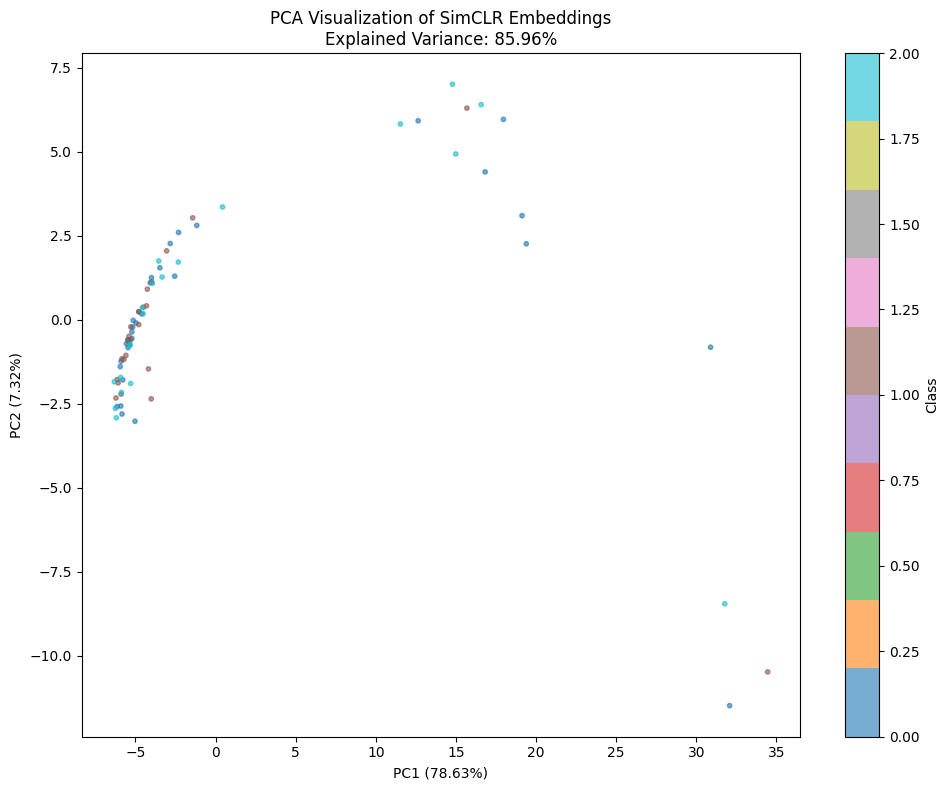

PCA Silhouette Score: -0.1217


In [17]:
def plot_pca(features, labels):
    """
    Create PCA visualization of embeddings colored by true labels
    """
    print("\n=== PCA Visualization ===")
    
    pca = PCA(n_components=2, random_state=42)
    features_2d = pca.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Class')
    plt.title(f'PCA Visualization of SimCLR Embeddings\n'
              f'Explained Variance: {pca.explained_variance_ratio_.sum():.2%}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.tight_layout()
    plt.savefig('pca_simclr.png', dpi=150)
    plt.show()
    
    # Compute Silhouette score
    sil_score = silhouette_score(features_2d, labels)
    print(f"PCA Silhouette Score: {sil_score:.4f}")
    
    return features_2d, sil_score


pca_features, pca_sil = plot_pca(X_test, y_test)



# 4.4  Evaluation Metrics - Detailed Evaluation


=== Detailed Metrics ===
Overall Accuracy: 0.3333

Per-Class Metrics:
Class           Precision    Recall       F1-Score     Support     
---------------------------------------------------------------
Akbar           0.3704       0.3125       0.3390       32          
Dilkash         0.4167       0.4348       0.4255       23          
Urooj           0.2083       0.2500       0.2273       20          

Macro Avg       0.3318       0.3324       0.3306      


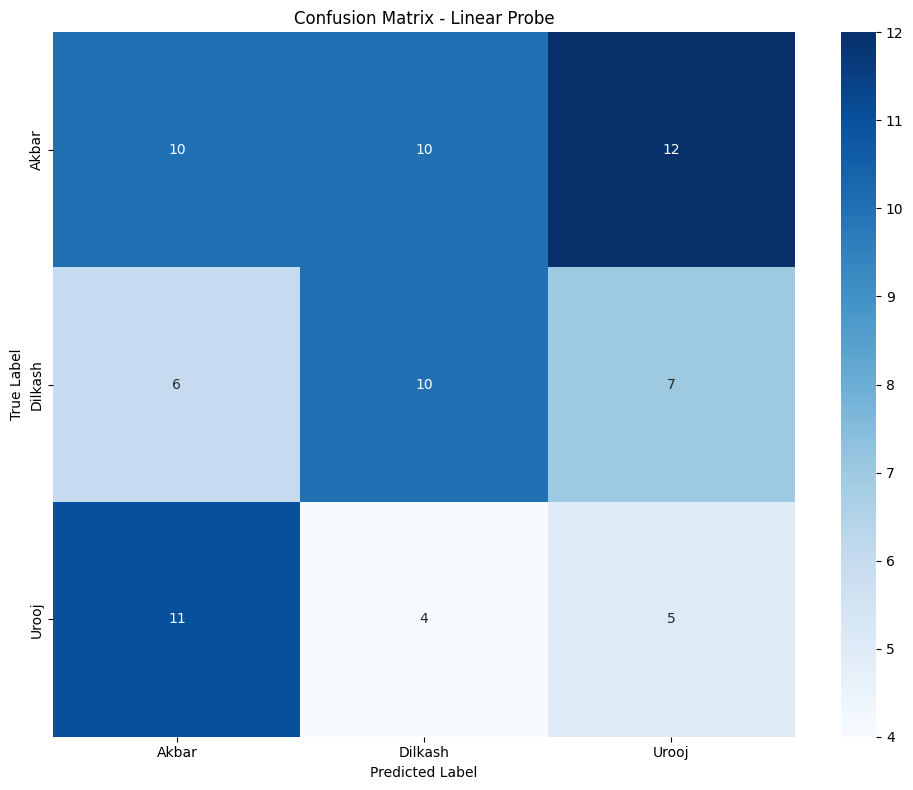

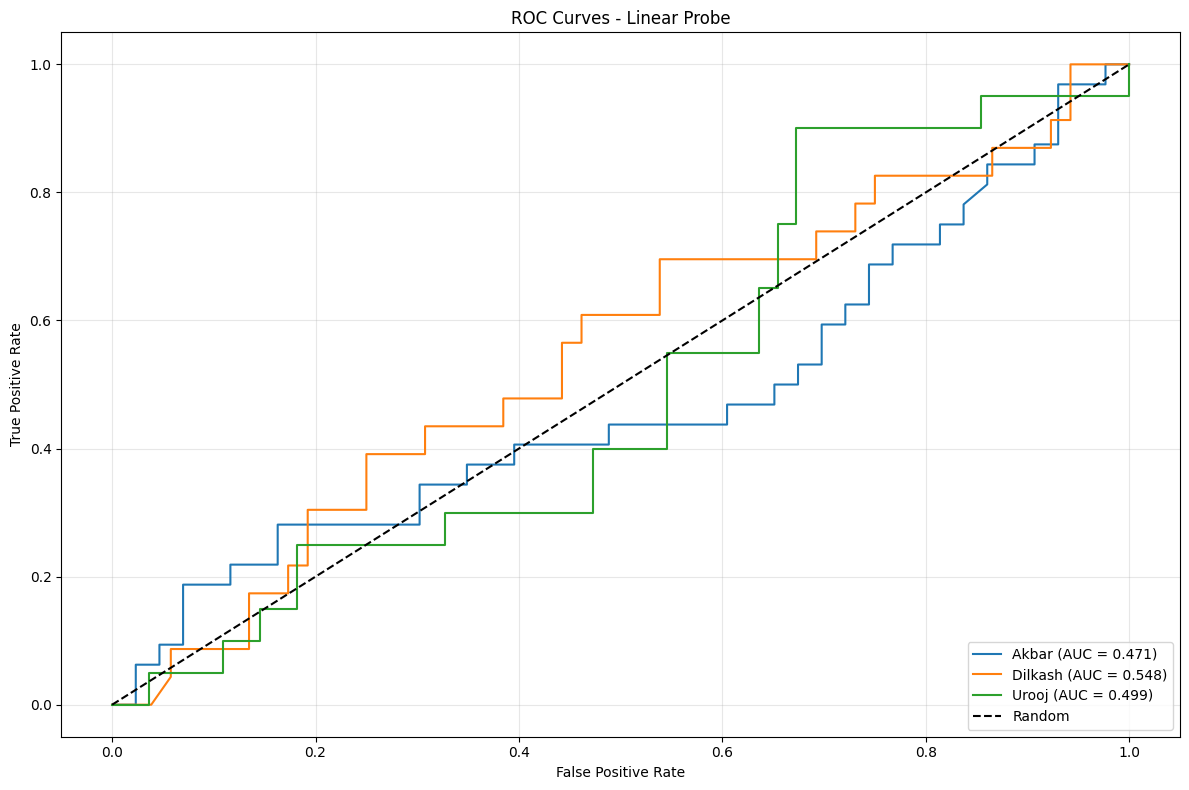


Average ROC-AUC: 0.5062


In [19]:

def compute_detailed_metrics(y_true, y_pred, y_pred_proba, class_names):
    """
    Compute comprehensive classification metrics
    """
    print("\n=== Detailed Metrics ===")
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )
    
    print("\nPer-Class Metrics:")
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print("-" * 63)
    for i, name in enumerate(class_names):
        print(f"{name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} "
              f"{f1[i]:<12.4f} {support[i]:<12}")
    
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    print(f"\n{'Macro Avg':<15} {prec_macro:<12.4f} {rec_macro:<12.4f} {f1_macro:<12.4f}")
    

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Linear Probe')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_simclr.png', dpi=150)
    plt.show()
    

    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    
    roc_auc = {}
    plt.figure(figsize=(12, 8))
    
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Linear Probe')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curves_simclr.png', dpi=150)
    plt.show()
    
    avg_roc_auc = np.mean(list(roc_auc.values()))
    print(f"\nAverage ROC-AUC: {avg_roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_roc_auc': avg_roc_auc,
        'confusion_matrix': cm
    }


class_names = ['Akbar', 'Dilkash', 'Urooj']

metrics = compute_detailed_metrics(y_test, linear_pred, linear_proba, class_names)

# 4.4 Evaluation Metrics K-NN Accuracy in Embedding Space

In [20]:
def evaluate_knn(X_train, y_train, X_test, y_test, k_values=[1, 5, 20]):
    """
    Evaluate k-NN classification in embedding space
    This measures the quality of learned representations
    """
    print("\n=== k-NN Evaluation ===")
    
    results = {}
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[k] = accuracy
        print(f"k={k}: Accuracy = {accuracy:.4f}")
    
    return results


knn_results = evaluate_knn(X_train, y_train, X_test, y_test)


=== k-NN Evaluation ===
k=1: Accuracy = 0.2533
k=5: Accuracy = 0.3467
k=20: Accuracy = 0.3333


# 4.4 Evaluation Metrics- Label Efficiency Curves

In [36]:

def evaluate_label_efficiency(X_train, y_train, X_test, y_test, 
                               fractions=[0.01, 0.05, 0.1, 0.25, 0.5, 1.0]):
    """
    Evaluate linear probe accuracy with different amounts of labeled data
    This shows how data-efficient the learned representations are
    """
    print("\n=== Label Efficiency Evaluation ===")
    
    results = {}
    
    for frac in fractions:
        n_samples = int(len(X_train) * frac)
        indices = np.random.choice(len(X_train), n_samples, replace=False)
        
        X_train_sub = X_train[indices]
        y_train_sub = y_train[indices]
        
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train_sub, y_train_sub)
        
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[frac] = accuracy
        print(f"{frac*100:.1f}% labels ({n_samples} samples): Accuracy = {accuracy:.4f}")
    

    plt.figure(figsize=(10, 6))
    fracs_pct = [f * 100 for f in results.keys()]
    accs = list(results.values())
    plt.plot(fracs_pct, accs, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Percentage of Labeled Data (%)')
    plt.ylabel('Linear Probe Accuracy')
    plt.title('Label Efficiency Curve - SimCLR')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('label_efficiency_simclr.png', dpi=150)
    plt.show()
    
    return results
    
    label_efficiency_results = evaluate_label_efficiency(X_train, y_train, X_test, y_test)


# 4.4 Evaluation Metrics- Learning Curves

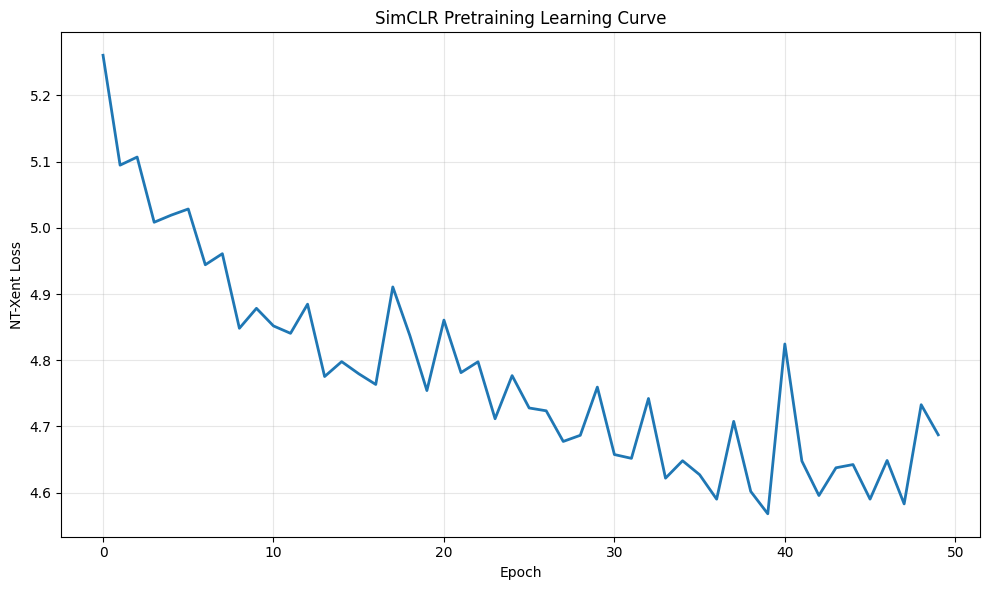

In [22]:
def plot_pretraining_curve(losses):
    """
    Plot the pretraining loss curve
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('NT-Xent Loss')
    plt.title('SimCLR Pretraining Learning Curve')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('pretraining_curve_simclr.png', dpi=150)
    plt.show()


plot_pretraining_curve(pretrain_losses)

# Comprehensive Results Summary

In [31]:


print("\n" + "="*80)
print("                      SIMCLR COMPREHENSIVE RESULTS")
print("="*80)

print("\n--- PRETRAINING ---")
print(f"Epochs: 50")
print(f"Pretraining Time: {pretrain_time:.2f}s ({pretrain_time/60:.2f} min)")
print(f"Final Loss: {pretrain_losses[-1]:.4f}")

print("\n--- LINEAR PROBE (Primary SSL Metric) ---")
print(f"Accuracy: {linear_acc:.4f}")
print(f"Train Time: {lp_train_time:.2f}s")
print(f"Test Time: {lp_test_time:.2f}s")

print("\n--- SHALLOW HEADS ---")
for name, result in shallow_results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.4f}, "
          f"Train Time = {result['train_time']:.2f}s")

print("\n--- FULL FINE-TUNING ---")
print(f"Accuracy: {finetune_acc:.4f}")
print(f"Improvement over Linear Probe: {(finetune_acc - linear_acc):.4f}")
print(f"Train Time: {ft_train_time:.2f}s ({ft_train_time/60:.2f} min)")

print("\n--- EMBEDDING QUALITY (Silhouette Scores) ---")
print(f"t-SNE: {tsne_sil:.4f}")
print(f"UMAP: {umap_sil:.4f}")
print(f"PCA: {pca_sil:.4f}")

print("\n--- k-NN ACCURACY ---")
for k, acc in knn_results.items():
    print(f"k={k}: {acc:.4f}")




                      SIMCLR COMPREHENSIVE RESULTS

--- PRETRAINING ---
Epochs: 50
Pretraining Time: 91.29s (1.52 min)
Final Loss: 4.6873

--- LINEAR PROBE (Primary SSL Metric) ---
Accuracy: 0.3333
Train Time: 3.96s
Test Time: 0.00s

--- SHALLOW HEADS ---
MLP: Accuracy = 0.4000, Train Time = 0.99s
SVM: Accuracy = 0.3333, Train Time = 0.02s
DecisionTree: Accuracy = 0.3200, Train Time = 0.15s
RandomForest: Accuracy = 0.3067, Train Time = 0.25s

--- FULL FINE-TUNING ---
Accuracy: 0.3867
Improvement over Linear Probe: 0.0533
Train Time: 11.45s (0.19 min)

--- EMBEDDING QUALITY (Silhouette Scores) ---
t-SNE: -0.0462
UMAP: -0.1224
PCA: -0.1217

--- k-NN ACCURACY ---
k=1: 0.2533
k=5: 0.3467
k=20: 0.3333


# Comparison Table Preparation

In [38]:
simclr_results = {
    'Method': 'SimCLR',
    

    'Pretrain_Time_min': pretrain_time / 60,
    'Pretrain_Loss': pretrain_losses[-1],
    

    'Linear_Probe_Acc': linear_acc,
    'LP_Train_Time_s': lp_train_time,
    'LP_Test_Time_s': lp_test_time,
    

    'MLP_Acc': shallow_results['MLP']['accuracy'],
    'SVM_Acc': shallow_results['SVM']['accuracy'],
    'DecisionTree_Acc': shallow_results['DecisionTree']['accuracy'],
    'RandomForest_Acc': shallow_results['RandomForest']['accuracy'],

    
    'FineTune_Acc': finetune_acc,
    'FineTune_Gain': finetune_acc - linear_acc,
    'FT_Train_Time_min': ft_train_time / 60,
    

    'tSNE_Silhouette': tsne_sil,
    'UMAP_Silhouette': umap_sil,
    'PCA_Silhouette': pca_sil,
    

    'kNN_k1': knn_results[1],
    'kNN_k5': knn_results[5],
    'kNN_k20': knn_results[20],
    

    'Avg_Precision': metrics['precision'].mean(),
    'Avg_Recall': metrics['recall'].mean(),
    'Avg_F1': metrics['f1'].mean(),
    'Avg_ROC_AUC': metrics['avg_roc_auc'],
    

    'GFLOPs': 0.56,  # Estimated for ResNet18 on 32x32
    'Params_M': 11.2,
}


import pandas as pd

df_results = pd.DataFrame([simclr_results])
df_results = df_results.T
df_results.columns = ['Value']

print("\n" + "="*80)
print("                  SIMCLR RESULTS FOR COMPARISON TABLE")
print("="*80)
print(df_results.to_string())


                  SIMCLR RESULTS FOR COMPARISON TABLE
                      Value
Method               SimCLR
Pretrain_Time_min  1.521528
Pretrain_Loss      4.687307
Linear_Probe_Acc   0.333333
LP_Train_Time_s    3.960829
LP_Test_Time_s     0.001273
MLP_Acc                 0.4
SVM_Acc            0.333333
DecisionTree_Acc       0.32
RandomForest_Acc   0.306667
FineTune_Acc       0.386667
FineTune_Gain      0.053333
FT_Train_Time_min  0.190767
tSNE_Silhouette   -0.046249
UMAP_Silhouette   -0.122362
PCA_Silhouette    -0.121672
kNN_k1             0.253333
kNN_k5             0.346667
kNN_k20            0.333333
Avg_Precision       0.33179
Avg_Recall         0.332428
Avg_F1             0.330596
Avg_ROC_AUC        0.506154
GFLOPs                 0.56
Params_M               11.2


# Visualization of all Metrics Together

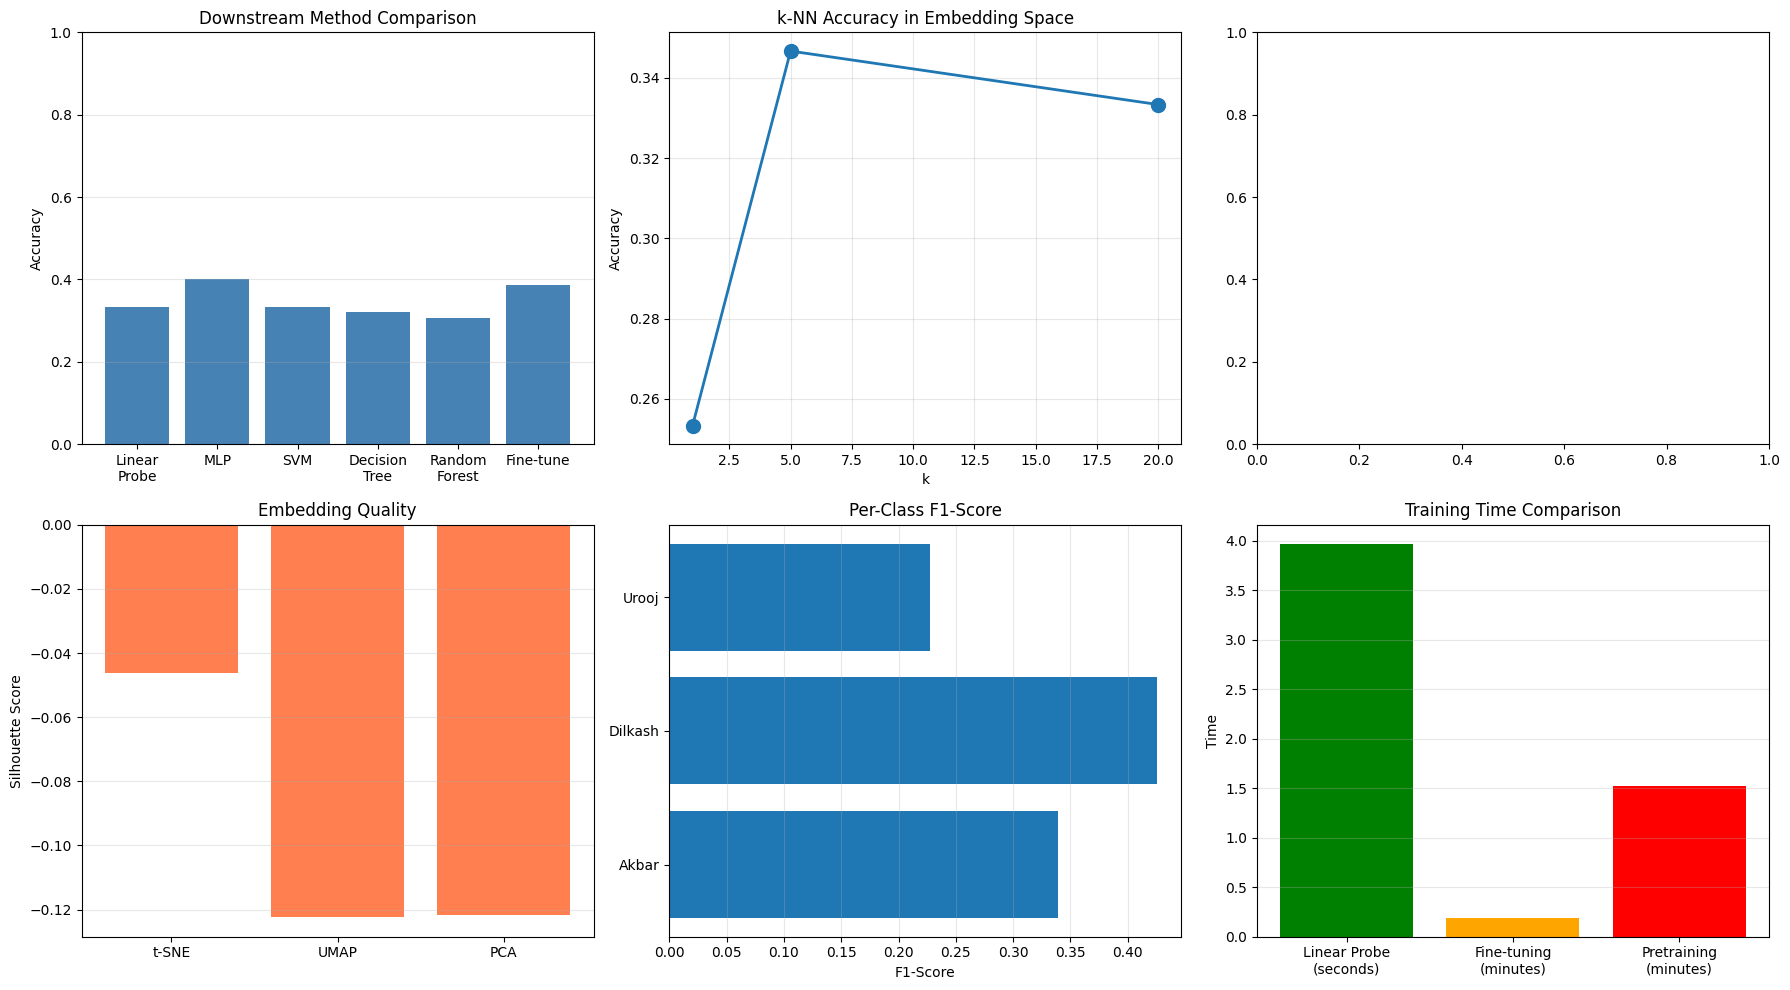

In [40]:
def plot_comprehensive_comparison():
    """
    Create comprehensive visualization of all evaluation metrics
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    methods = ['Linear\nProbe', 'MLP', 'SVM', 'Decision\nTree', 
               'Random\nForest', 'Fine-tune']
    accuracies = [
        linear_acc,
        shallow_results['MLP']['accuracy'],
        shallow_results['SVM']['accuracy'],
        shallow_results['DecisionTree']['accuracy'],
        shallow_results['RandomForest']['accuracy'],
        finetune_acc
    ]
    
    axes[0, 0].bar(methods, accuracies, color='steelblue')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Downstream Method Comparison')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].grid(axis='y', alpha=0.3)

    k_vals = list(knn_results.keys())
    k_accs = list(knn_results.values())
    axes[0, 1].plot(k_vals, k_accs, marker='o', linewidth=2, markersize=10)
    axes[0, 1].set_xlabel('k')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('k-NN Accuracy in Embedding Space')
    axes[0, 1].grid(alpha=0.3)
    
    

    emb_methods = ['t-SNE', 'UMAP', 'PCA']
    sil_scores = [tsne_sil, umap_sil, pca_sil]
    axes[1, 0].bar(emb_methods, sil_scores, color='coral')
    axes[1, 0].set_ylabel('Silhouette Score')
    axes[1, 0].set_title('Embedding Quality')
    axes[1, 0].grid(axis='y', alpha=0.3)

    axes[1, 1].barh(class_names, metrics['f1'])
    axes[1, 1].set_xlabel('F1-Score')
    axes[1, 1].set_title('Per-Class F1-Score')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    times = [lp_train_time, ft_train_time/60, pretrain_time/60]
    time_labels = ['Linear Probe\n(seconds)', 'Fine-tuning\n(minutes)', 
                   'Pretraining\n(minutes)']
    colors = ['green', 'orange', 'red']
    axes[1, 2].bar(time_labels, times, color=colors)
    axes[1, 2].set_ylabel('Time')
    axes[1, 2].set_title('Training Time Comparison')
    axes[1, 2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('comprehensive_metrics_simclr.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_comprehensive_comparison()
